# 증강 프롬프트 참고용 수집피싱데이터 EDA, 생성데이터포함 EDA(csv 파일만 수정하여 2번 시행)

폰트 설정 완료: 'Malgun Gothic' 폰트를 직접 지정했습니다.

### 발화자(피싱범/피해자)별 기본 통계 (Kiwi 기준) ###
         총 발화 수  평균 발화 길이   총 글자 수
피싱범 (0)   23281     43.31  1008399
피해자 (1)   21238     28.17   598284


### 피싱범(speaker=0)이 주로 사용하는 키워드 Top 20 (Kiwi 기준) ###
본인: 4063회
저희: 3491회
고객: 2495회
확인: 2412회
계좌: 1941회
통장: 1803회
부분: 1571회
말씀: 1564회
사건: 1407회
연락: 1358회
은행: 1327회
금융: 1311회
때문: 1281회
진행: 1207회
조사: 1105회
정보: 1091회
필요: 1068회
전화: 1053회
처리: 996회
대출: 983회


### 피해자(speaker=1)가 주로 사용하는 키워드 Top 20 (Kiwi 기준) ###
본인: 1726회
말씀: 1206회
통장: 1023회
확인: 982회
고객: 952회
전화: 938회
저희: 901회
계좌: 803회
은행: 748회
사용: 602회
부분: 574회
연락: 539회
그거: 528회
이거: 519회
정보: 491회
사건: 454회
때문: 448회
번호: 435회
대출: 428회
정도: 402회


시각화 파일 'speaker_stats_comparison_kiwi_font_fixed.png' 이 저장되었습니다.


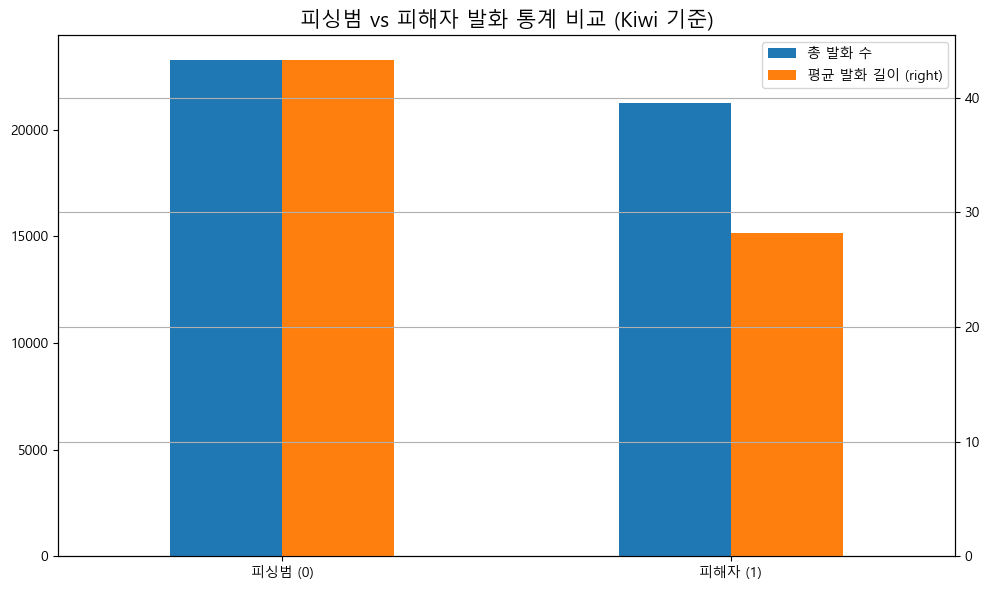

In [12]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from kiwipiepy import Kiwi
import matplotlib.font_manager as fm # 폰트 관리를 위한 모듈 임포트
import os # 파일 경로를 확인하기 위한 모듈 임포트

# --- 폰트 설정 (가장 확실한 방법: 폰트 파일 경로 직접 지정) ---
# 1. 사용할 폰트 파일의 전체 경로를 변수에 할당합니다.
#    (윈도우 사용자의 경우, '맑은 고딕' 폰트는 보통 아래 경로에 있습니다.)
font_path = 'C:/Windows/Fonts/malgun.ttf'

# 2. 해당 경로에 파일이 실제로 존재하는지 확인합니다.
if os.path.exists(font_path):
    # 3. 경로를 이용해 matplotlib에 폰트 등록 및 전역 설정
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['font.family'] = font_name
    print(f"폰트 설정 완료: '{font_name}' 폰트를 직접 지정했습니다.")
else:
    # 4. 만약 파일이 없다면, 경고 메시지를 출력합니다.
    print(f"경고: 지정된 경로에 폰트 파일이 없습니다: {font_path}")
    print("C:/Windows/Fonts 폴더에서 'malgun.ttf' 또는 다른 한글 폰트 파일의 정확한 경로를 확인하여 위 'font_path' 변수를 수정해주세요.")

# 마이너스 부호가 깨지는 현상을 방지하는 설정
plt.rcParams['axes.unicode_minus'] = False


# --- (여기부터 아래의 모든 코드는 네가 준 코드와 동일) ---

# --- 데이터 로드 ---
try:
    df = pd.read_csv("phishing_total.csv")
    df['char_count'] = df['text'].str.len()
except FileNotFoundError:
    print("phishing_total.csv 파일을 찾을 수 없습니다.")
    df = pd.DataFrame()

# --- Kiwi 형태소 분석기 초기화 ---
try:
    kiwi = Kiwi()
except Exception as e:
    kiwi = None
    print(f"Kiwi 초기화 오류: {e}.")

def get_nouns_kiwi(text):
    if kiwi:
        return [token.form for token in kiwi.tokenize(text) if token.tag.startswith('N') and len(token.form) > 1]
    return []

if not df.empty:
    # --- 발화자별 기본 통계 분석 ---
    speaker_stats = df.groupby('speaker')['char_count'].agg(['count', 'mean', 'sum'])
    speaker_stats.index = ['피싱범 (0)', '피해자 (1)']
    speaker_stats.columns = ['총 발화 수', '평균 발화 길이', '총 글자 수']

    print("\n### 발화자(피싱범/피해자)별 기본 통계 (Kiwi 기준) ###")
    print(speaker_stats)
    print("\n" + "="*50 + "\n")

    # --- 발화자별 핵심 키워드 분석 ---
    if kiwi:
        phisher_corpus = df[df['speaker'] == 0]['text']
        phisher_nouns = [noun for text in phisher_corpus for noun in get_nouns_kiwi(text)]
        phisher_word_counts = Counter(phisher_nouns)
        
        print("### 피싱범(speaker=0)이 주로 사용하는 키워드 Top 20 (Kiwi 기준) ###")
        for word, count in phisher_word_counts.most_common(20):
            print(f"{word}: {count}회")
        print("\n" + "="*50 + "\n")

        victim_corpus = df[df['speaker'] == 1]['text']
        victim_nouns = [noun for text in victim_corpus for noun in get_nouns_kiwi(text)]
        victim_word_counts = Counter(victim_nouns)

        print("### 피해자(speaker=1)가 주로 사용하는 키워드 Top 20 (Kiwi 기준) ###")
        for word, count in victim_word_counts.most_common(20):
            print(f"{word}: {count}회")
        print("\n" + "="*50 + "\n")

    # --- 시각화 ---
    plt.figure(figsize=(10, 6)) # 그래프 사이즈를 명시적으로 지정
    speaker_stats[['총 발화 수', '평균 발화 길이']].plot(
        kind='bar', 
        rot=0, 
        ax=plt.gca(), # 현재 axes를 지정하여 그래프를 그림
        secondary_y='평균 발화 길이',
        grid=True
    )
    plt.title('피싱범 vs 피해자 발화 통계 비교 (Kiwi 기준)', fontsize=15)
    plt.tight_layout() # 그래프 요소들이 겹치지 않게 조정
    plt.savefig('speaker_stats_comparison_kiwi_font_fixed.png')
    print("시각화 파일 'speaker_stats_comparison_kiwi_font_fixed.png' 이 저장되었습니다.")
else:
    print("데이터프레임이 비어있어 분석을 진행할 수 없습니다.")

In [13]:
# -*- coding: utf-8 -*-
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from kiwipiepy import Kiwi
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# --- 폰트 설정 (직접 경로 지정) ---
font_path = "C:/Windows/Fonts/malgun.ttf"
if os.path.exists(font_path):
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams["font.family"] = font_name
    print(f"폰트 설정 완료: '{font_name}' 폰트를 직접 지정했습니다.")
else:
    print(f"경고: 지정된 경로에 폰트 파일이 없습니다: {font_path}")
plt.rcParams["axes.unicode_minus"] = False


# --- 데이터 로드 및 재구성 ---
try:
    df_original = pd.read_csv("phishing_total.csv")
    dialogue_df = (
        df_original.groupby(["file_name", "phishing_type"])["text"]
        .apply(lambda x: "\n".join(x))
        .reset_index()
    )
except FileNotFoundError:
    print("phishing_total.csv 파일을 찾을 수 없습니다.")
    dialogue_df = pd.DataFrame()

# --- Kiwi 형태소 분석기 초기화 ---
try:
    kiwi = Kiwi()
except Exception as e:
    kiwi = None
    print(f"Kiwi 초기화 오류: {e}.")


# (이하 함수 정의는 동일)
def get_nouns_kiwi(text):
    if kiwi:
        return [
            token.form
            for token in kiwi.tokenize(text)
            if token.tag.startswith("N") and len(token.form) > 1
        ]
    return []


def get_ngrams(corpus, ngram_range=(2, 2)):
    vectorizer = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq


# --- 여기가 핵심 부분 ---
if not dialogue_df.empty:
    # 1. 데이터에 있는 모든 'phishing_type'의 고유한 값들을 가져온다.
    phishing_types = dialogue_df["phishing_type"].unique()
    print(f"\n분석할 보이스피싱 유형 목록: {list(phishing_types)}")
    print("=" * 50)

    # 2. for 반복문을 통해, 위에서 찾은 모든 유형에 대해 분석을 순차적으로 실행한다.
    for p_type in phishing_types:
        # 현재 분석 중인 유형의 이름을 출력한다.
        print(f"\n--- 분석 유형: {p_type} (Kiwi 기준) ---")

        type_corpus = dialogue_df[dialogue_df["phishing_type"] == p_type]["text"]

        # (키워드 및 N-gram 분석 로직은 동일)
        if kiwi:
            print("\n[1] 핵심 키워드 (Top 15 명사)")
            all_nouns = [noun for text in type_corpus for noun in get_nouns_kiwi(text)]
            noun_counts = Counter(all_nouns)
            for noun, count in noun_counts.most_common(15):
                print(f"{noun}: {count}회")

        print("\n[2] 주요 표현 (Top 10 Bi-grams)")
        for bigram, count in get_ngrams(type_corpus, (2, 2))[:10]:
            print(f"'{bigram}': {count}회")

        print("\n[3] 주요 표현 (Top 10 Tri-grams)")
        for trigram, count in get_ngrams(type_corpus, (3, 3))[:10]:
            print(f"'{trigram}': {count}회")

        print("\n" + "=" * 50)
else:
    print("데이터프레임이 비어있어 분석을 진행할 수 없습니다.")

폰트 설정 완료: 'Malgun Gothic' 폰트를 직접 지정했습니다.

분석할 보이스피싱 유형 목록: ['가족지인사칭형', '세금환급형', '기관사칭형', '대출빙자형', '메신저피싱형', '택배사칭형', '콜백스미싱형', '투자권유형']

--- 분석 유형: 가족지인사칭형 (Kiwi 기준) ---

[1] 핵심 키워드 (Top 15 명사)
본인: 141회
필요: 110회
고객: 88회
전화: 82회
계좌: 82회
어디: 78회
통장: 73회
저희: 71회
연락: 66회
친구: 64회
은행: 63회
번호: 56회
사고: 55회
말씀: 51회
확인: 51회

[2] 주요 표현 (Top 10 Bi-grams)
'무슨 일이야': 29회
'고장 나서': 19회
'사고가 나서': 18회
'여보세요 ooo야': 16회
'친구가 사고가': 15회
'병원비가 필요해': 14회
'나중에 설명할게': 13회
'보내줄 있어': 12회
'예를 들어서': 12회
'지금 현재': 12회

[3] 주요 표현 (Top 10 Tri-grams)
'친구가 사고가 나서': 11회
'ooo 무슨 일이야': 7회
'고장 나서 임시': 7회
'휴대폰이 고장 나서': 6회
'핸드폰이 고장 나서': 5회
'무슨 일인데 그래': 5회
'나한테 얼마 해줄': 5회
'나서 병원비가 필요해': 4회
'사고가 나서 병원비가': 4회
'폰이 고장 나서': 4회


--- 분석 유형: 세금환급형 (Kiwi 기준) ---

[1] 핵심 키워드 (Top 15 명사)
환급: 262회
계좌: 198회
세금: 171회
번호: 166회
확인: 110회
정보: 109회
필요: 93회
환급금: 71회
연락: 67회
은행: 66회
안녕하세요: 59회
주민: 51회
등록: 49회
작년: 45회
처리: 45회

[2] 주요 표현 (Top 10 Bi-grams)
'세금 환급': 45회
'어떻게 해야': 32회
'안녕하세요 ooo님': 28회
'해야 하나요': 26회
'확인을 위해': 21회
'연락드렸습니다 세금': 16회
'알려주시

폰트 설정 완료: 'Malgun Gothic' 폰트를 직접 지정했습니다.

### 피싱 유형별 턴 길이 상세 통계 ###
               count       mean         std   min    25%   50%     75%    max
phishing_type                                                                
가족지인사칭형         25.0  38.480000   56.327258   1.0   5.00  23.0   39.00  266.0
기관사칭형          446.0  57.737668  101.083904   1.0   5.00  23.0   58.75  766.0
대출빙자형          272.0  36.125000   43.850288   1.0   7.75  25.0   46.00  411.0
메신저피싱형           8.0  34.375000   28.132023   1.0  16.25  29.5   52.00   78.0
세금환급형            3.0  69.333333   92.915732   6.0  16.00  26.0  101.00  176.0
콜백스미싱형           8.0  17.625000   22.264241   1.0   3.50  12.5   20.00   69.0
택배사칭형            1.0  15.000000         NaN  15.0  15.00  15.0   15.00   15.0
투자권유형            5.0  72.400000  129.478956   4.0   7.00  13.0   35.00  303.0

시각화 파일 'turn_count_by_type_boxplot.png'이 저장되었습니다.


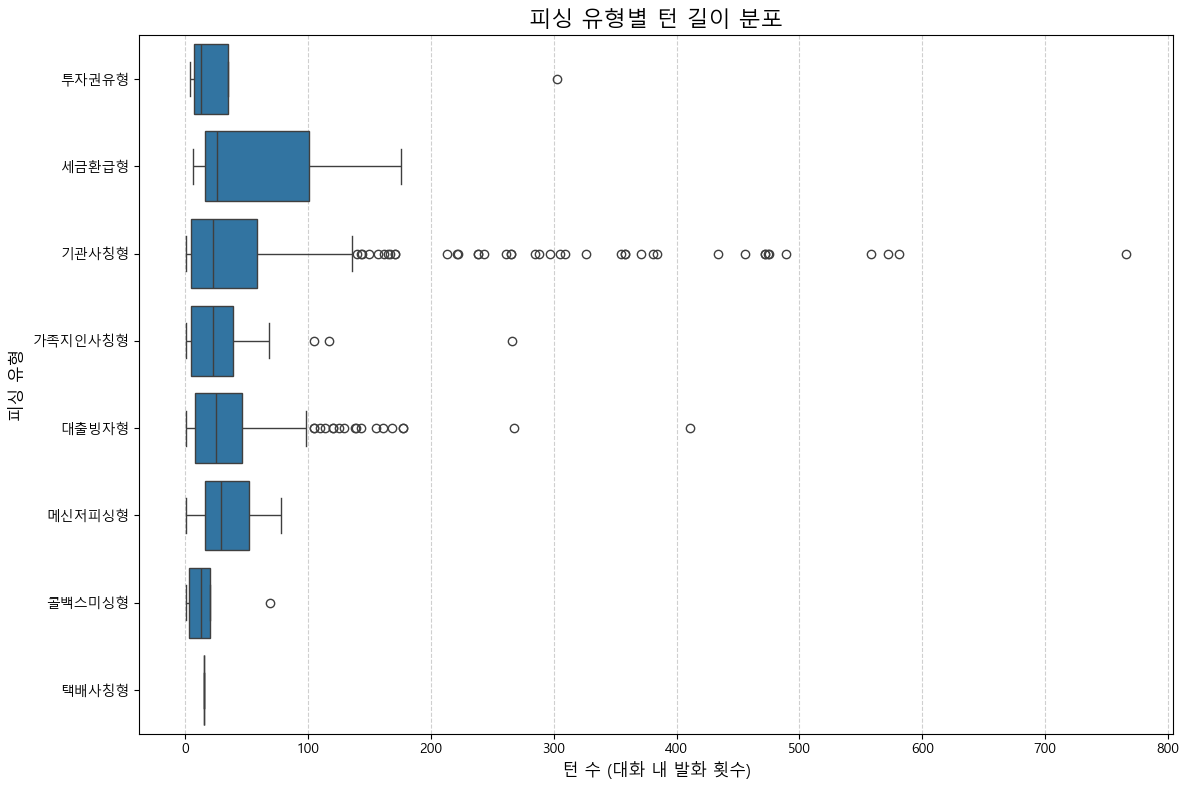

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os

# --- 폰트 설정 (가장 확실한 방법: 폰트 파일 경로 직접 지정) ---
font_path = "C:/Windows/Fonts/malgun.ttf"
if os.path.exists(font_path):
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams["font.family"] = font_name
    print(f"폰트 설정 완료: '{font_name}' 폰트를 직접 지정했습니다.")
else:
    print(f"경고: 지정된 경로에 폰트 파일이 없습니다: {font_path}")
plt.rcParams["axes.unicode_minus"] = False


# --- 데이터 로드 ---
try:
    df = pd.read_csv("phishing_total.csv")
except FileNotFoundError:
    print("phishing_total.csv 파일을 찾을 수 없습니다.")
    df = pd.DataFrame()

if not df.empty:
    # 1. file_name과 phishing_type을 기준으로 그룹화하여 각 대화의 턴 수를 계산한다.
    #    size() 함수는 각 그룹의 크기(행의 개수)를 반환하므로, 이게 바로 대화별 턴 수가 된다.
    turn_counts_df = (
        df.groupby(["file_name", "phishing_type"]).size().reset_index(name="turn_count")
    )

    # 2. 이제 phishing_type을 기준으로 그룹화하여 turn_count에 대한 상세 통계를 계산한다.
    #    describe() 함수는 개수(count), 평균(mean), 표준편차(std), 최소(min), 최대(max) 및 사분위수 값을 모두 보여준다.
    print("\n### 피싱 유형별 턴 길이 상세 통계 ###")
    turn_stats = turn_counts_df.groupby("phishing_type")["turn_count"].describe()
    print(turn_stats)
    print("\n" + "=" * 50)

    # 3. 시각화: 박스 플롯(Box Plot)으로 유형별 턴 길이 분포를 확인한다.
    #    박스 플롯은 데이터의 분포와 이상치(outlier)를 한눈에 보기에 매우 유용하다.
    plt.figure(figsize=(12, 8))
    sns.boxplot(
        y="phishing_type",
        x="turn_count",
        data=turn_counts_df,
        orient="h",
        order=turn_stats.sort_values(by="mean", ascending=False).index,
    )

    plt.title("피싱 유형별 턴 길이 분포", fontsize=16)
    plt.xlabel("턴 수 (대화 내 발화 횟수)", fontsize=12)
    plt.ylabel("피싱 유형", fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()

    # 그래프 파일로 저장
    plt.savefig("turn_count_by_type_boxplot.png")
    print("시각화 파일 'turn_count_by_type_boxplot.png'이 저장되었습니다.")
else:
    print("데이터프레임이 비어있어 분석을 진행할 수 없습니다.")

In [14]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os

# --- 폰트 설정 (가장 확실한 방법: 폰트 파일 경로 직접 지정) ---
font_path = "C:/Windows/Fonts/malgun.ttf"
if os.path.exists(font_path):
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams["font.family"] = font_name
    print(f"폰트 설정 완료: '{font_name}' 폰트를 직접 지정했습니다.")
else:
    print(f"경고: 지정된 경로에 폰트 파일이 없습니다: {font_path}")
plt.rcParams["axes.unicode_minus"] = False


# --- 데이터 로드 및 피처 계산 (이전과 동일) ---
try:
    df = pd.read_csv("phishing_total.csv")
except FileNotFoundError:
    print("phishing_total.csv 파일을 찾을 수 없습니다.")
    df = pd.DataFrame()

if not df.empty:
    df["word_count"] = df["text"].str.split().str.len()
    df["sentence_count"] = (
        df["text"]
        .apply(lambda x: len([s for s in re.split(r"[.?!]", x) if s.strip()]))
        .replace(0, 1)
    )
    df["avg_sentence_length"] = (df["text"].str.len() / df["sentence_count"]).fillna(0)

    # --- 통계표 계산 (이전과 동일) ---
    phishing_total_df = df.groupby(["phishing_type", "speaker"])[
        ["word_count", "avg_sentence_length"]
    ].mean()
    final_table = phishing_total_df.unstack()
    final_table.columns = [
        "피싱범 평균 단어 수",
        "피해자 평균 단어 수",
        "피싱범 평균 문장 길이",
        "피해자 평균 문장 길이",
    ]
    pd.options.display.float_format = "{:.2f}".format
    print("=" * 80)
    print("### 유형별/발화자별 평균 단어 수 및 문장 길이 비교표 ###")
    print(final_table)
    print("=" * 80)

    # --- 여기서부터 시각화 코드 추가 ---

    # 1. 유형별 '평균 단어 수' 비교 그래프
    plt.figure(figsize=(12, 8))
    word_count_df = final_table[["피싱범 평균 단어 수", "피해자 평균 단어 수"]]
    # 평균값 기준으로 정렬하여 보기 좋게 만듦
    word_count_df.sort_values(by="피싱범 평균 단어 수").plot(
        kind="barh", ax=plt.gca(), grid=True
    )
    plt.title("유형별/발화자별 턴 당 평균 단어 수 비교", fontsize=16)
    plt.xlabel("평균 단어 수", fontsize=12)
    plt.ylabel("피싱 유형", fontsize=12)
    plt.legend(title="발화자")
    plt.tight_layout()
    plt.savefig("word_count_comparison.png")
    print("시각화 파일 'word_count_comparison.png'이 저장되었습니다.")
    plt.close()  # 그래프 창을 닫아 다음 그래프에 영향이 없도록 함

    # 2. 유형별 '평균 문장 길이' 비교 그래프
    plt.figure(figsize=(12, 8))
    sentence_length_df = final_table[["피싱범 평균 문장 길이", "피해자 평균 문장 길이"]]
    sentence_length_df.sort_values(by="피싱범 평균 문장 길이").plot(
        kind="barh", ax=plt.gca(), grid=True
    )
    plt.title("유형별/발화자별 턴 당 평균 문장 길이 비교", fontsize=16)
    plt.xlabel("평균 문장 길이 (글자 수)", fontsize=12)
    plt.ylabel("피싱 유형", fontsize=12)
    plt.legend(title="발화자")
    plt.tight_layout()
    plt.savefig("sentence_length_comparison.png")
    print("시각화 파일 'sentence_length_comparison.png'이 저장되었습니다.")
    plt.close()

else:
    print("데이터프레임이 비어있어 분석을 진행할 수 없습니다.")

폰트 설정 완료: 'Malgun Gothic' 폰트를 직접 지정했습니다.
### 유형별/발화자별 평균 단어 수 및 문장 길이 비교표 ###
               피싱범 평균 단어 수  피해자 평균 단어 수  피싱범 평균 문장 길이  피해자 평균 문장 길이
phishing_type                                                      
가족지인사칭형               9.49         7.42         28.16         21.19
기관사칭형                11.34         7.42         35.46         21.32
대출빙자형                10.79         8.06         31.78         22.58
메신저피싱형                8.55         5.74         25.65         16.77
세금환급형                 9.52         6.61         30.52         20.05
콜백스미싱형                8.02         4.34         26.38         13.56
택배사칭형                 7.44         4.87         22.81         12.64
투자권유형                10.81         5.29         28.37         16.86
시각화 파일 'word_count_comparison.png'이 저장되었습니다.
시각화 파일 'sentence_length_comparison.png'이 저장되었습니다.


In [16]:
# -*- coding: utf-8 -*-
import pandas as pd
from collections import Counter
from kiwipiepy import Kiwi

# --- Kiwi 형태소 분석기 및 명사 추출 함수 준비 ---
try:
    kiwi = Kiwi()
except Exception as e:
    kiwi = None
    print(f"Kiwi 초기화 오류: {e}.")


def get_nouns_kiwi(text):
    if kiwi:
        if not isinstance(text, str) or not text.strip():
            return []
        return [
            token.form
            for token in kiwi.tokenize(text)
            if token.tag.startswith("N") and len(token.form) > 1
        ]
    return []


# --- 데이터 분석 결과를 요약해서 반환하는 함수 정의 ---
def summarize_dataset(df):
    """데이터프레임을 받아 통계와 키워드를 요약하여 반환하는 함수"""

    # 1. 기본 통계 요약
    df["char_count"] = df["text"].str.len()
    speaker_stats = df.groupby("speaker")["char_count"].agg(["count", "mean", "sum"])

    phisher_stats = speaker_stats.loc[0]  # 피싱범(0) 통계
    victim_stats = speaker_stats.loc[1]  # 피해자(1) 통계

    stats_summary = {
        "피싱범 총 발화 수": phisher_stats["count"],
        "피싱범 평균 발화 길이": phisher_stats["mean"],
        "피싱범 총 글자 수": phisher_stats["sum"],
        "피해자 총 발화 수": victim_stats["count"],
        "피해자 평균 발화 길이": victim_stats["mean"],
        "피해자 총 글자 수": victim_stats["sum"],
    }

    # 2. 키워드 요약
    phisher_corpus = df[df["speaker"] == 0]["text"].dropna()
    phisher_nouns = [noun for text in phisher_corpus for noun in get_nouns_kiwi(text)]
    phisher_top20 = [
        f"{word} ({count}회)" for word, count in Counter(phisher_nouns).most_common(20)
    ]

    victim_corpus = df[df["speaker"] == 1]["text"].dropna()
    victim_nouns = [noun for text in victim_corpus for noun in get_nouns_kiwi(text)]
    victim_top20 = [
        f"{word} ({count}회)" for word, count in Counter(victim_nouns).most_common(20)
    ]

    # 키워드 목록의 길이를 20으로 맞춤
    while len(phisher_top20) < 20:
        phisher_top20.append("")
    while len(victim_top20) < 20:
        victim_top20.append("")

    keyword_summary = {f"피싱범 Top {i+1}": phisher_top20[i] for i in range(20)}
    keyword_summary.update({f"피해자 Top {i+1}": victim_top20[i] for i in range(20)})

    # 통계와 키워드를 합쳐서 반환
    stats_summary.update(keyword_summary)

    return pd.Series(stats_summary)


# --- 메인 실행 부분 ---
files_to_compare = ["phishing_total.csv", "result.csv"]
all_results = []

print("각 파일별로 분석을 시작합니다...")
for file in files_to_compare:
    try:
        df = pd.read_csv(file)
        # 위에서 정의한 요약 함수를 호출
        result_series = summarize_dataset(df)
        result_series.name = file  # Series의 이름을 파일명으로 지정
        all_results.append(result_series)
        print(f"'{file}' 분석 완료.")
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: '{file}'")
    except Exception as e:
        print(f"'{file}' 파일을 처리하는 중 오류가 발생했습니다: {e}")

# 모든 결과를 하나의 데이터프레임으로 합침
if all_results:
    # 각 파일의 결과(Series)가 열(column)이 되도록 합친다
    final_comparison_df = pd.concat(all_results, axis=1)

    # 소수점 둘째 자리까지만 표시되도록 설정
    pd.options.display.float_format = "{:.2f}".format

    print("\n\n" + "=" * 80)
    print("### 두 데이터셋 비교 분석 요약표 ###")
    print("=" * 80)
    print(final_comparison_df)

    # 최종 비교표를 CSV 파일로 저장
    final_comparison_df.to_csv("comparison_report.csv", encoding="utf-8-sig")
    print("\n두 파일의 비교 결과를 'comparison_report.csv' 파일 하나로 저장했습니다.")
else:
    print(
        "\n분석할 파일이 없거나 분석 중 오류가 발생하여 비교 파일을 생성하지 못했습니다."
    )

각 파일별로 분석을 시작합니다...
'phishing_total.csv' 분석 완료.
'result.csv' 분석 완료.


### 두 데이터셋 비교 분석 요약표 ###
             phishing_total.csv  result.csv
피싱범 총 발화 수             23281.00    19427.00
피싱범 평균 발화 길이              43.31       44.81
피싱범 총 글자 수           1008399.00   870605.00
피해자 총 발화 수             21238.00    18113.00
피해자 평균 발화 길이              28.17       29.65
피해자 총 글자 수            598284.00   537027.00
피싱범 Top 1            본인 (4063회)  본인 (3972회)
피싱범 Top 2            저희 (3491회)  저희 (3180회)
피싱범 Top 3            고객 (2495회)  고객 (2137회)
피싱범 Top 4            확인 (2412회)  통장 (1803회)
피싱범 Top 5            계좌 (1941회)  부분 (1560회)
피싱범 Top 6            통장 (1803회)  말씀 (1524회)
피싱범 Top 7            부분 (1571회)  계좌 (1389회)
피싱범 Top 8            말씀 (1564회)  확인 (1387회)
피싱범 Top 9            사건 (1407회)  사건 (1359회)
피싱범 Top 10           연락 (1358회)  때문 (1276회)
피싱범 Top 11           은행 (1327회)  금융 (1231회)
피싱범 Top 12           금융 (1311회)  은행 (1186회)
피싱범 Top 13           때문 (1281회)  진행 (1091회)
피싱범 Top 14           진행 (

In [17]:
# -*- coding: utf-8 -*-
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from kiwipiepy import Kiwi
import os

# --- Kiwi 형태소 분석기 및 함수 준비 ---
try:
    kiwi = Kiwi()
except Exception as e:
    kiwi = None
    print(f"Kiwi 초기화 오류: {e}.")


def get_nouns_kiwi(text):
    if kiwi:
        if not isinstance(text, str) or not text.strip():
            return []
        return [
            token.form
            for token in kiwi.tokenize(text)
            if token.tag.startswith("N") and len(token.form) > 1
        ]
    return []


def get_ngrams(corpus, ngram_range=(2, 2), top_n=10):
    if corpus.empty:
        return [f"" for _ in range(top_n)]
    try:
        vectorizer = CountVectorizer(ngram_range=ngram_range).fit(corpus)
        bag_of_words = vectorizer.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        top_list = [f"'{word}' ({count}회)" for word, count in words_freq[:top_n]]
        while len(top_list) < top_n:
            top_list.append("")
        return top_list
    except ValueError:  # 말뭉치가 비어있을 경우 에러 방지
        return [f"" for _ in range(top_n)]


# --- 데이터셋의 유형별 N-gram을 요약하는 함수 ---
def summarize_ngrams_by_type(df):
    """데이터프레임을 받아 유형별 키워드와 N-gram을 요약하여 반환하는 함수"""

    summary_dict = {}

    # 대화 단위로 데이터 재구성
    dialogue_df = (
        df.groupby(["file_name", "phishing_type"])["text"]
        .apply(lambda x: "\n".join(x))
        .reset_index()
    )

    phishing_types = dialogue_df["phishing_type"].unique()

    for p_type in phishing_types:
        type_corpus = dialogue_df[dialogue_df["phishing_type"] == p_type][
            "text"
        ].dropna()

        # 1. 핵심 키워드 요약
        all_nouns = [noun for text in type_corpus for noun in get_nouns_kiwi(text)]
        top_15_nouns = [
            f"{word} ({count}회)" for word, count in Counter(all_nouns).most_common(15)
        ]
        while len(top_15_nouns) < 15:
            top_15_nouns.append("")
        for i, item in enumerate(top_15_nouns):
            summary_dict[f"{p_type}_명사_Top{i+1}"] = item

        # 2. Bi-gram 요약
        top_10_bigrams = get_ngrams(type_corpus, ngram_range=(2, 2), top_n=10)
        for i, item in enumerate(top_10_bigrams):
            summary_dict[f"{p_type}_2-gram_Top{i+1}"] = item

        # 3. Tri-gram 요약
        top_10_trigrams = get_ngrams(type_corpus, ngram_range=(3, 3), top_n=10)
        for i, item in enumerate(top_10_trigrams):
            summary_dict[f"{p_type}_3-gram_Top{i+1}"] = item

    return pd.Series(summary_dict)


# --- 메인 실행 부분 ---
files_to_compare = ["phishing_total.csv", "result.csv"]
all_summaries = []

print("각 파일별로 N-gram 분석을 시작합니다...")
for file in files_to_compare:
    try:
        df = pd.read_csv(file)
        # 위에서 정의한 요약 함수를 호출
        summary_series = summarize_ngrams_by_type(df)
        summary_series.name = file  # Series의 이름을 파일명으로 지정
        all_summaries.append(summary_series)
        print(f"'{file}' 분석 완료.")
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: '{file}'")
    except Exception as e:
        print(f"'{file}' 파일을 처리하는 중 오류가 발생했습니다: {e}")

# 모든 결과를 하나의 데이터프레임으로 합침
if all_summaries:
    final_comparison_df = pd.concat(all_summaries, axis=1)

    # 행 인덱스(분석 항목) 기준으로 정렬
    final_comparison_df.sort_index(inplace=True)

    print("\n\n" + "=" * 80)
    print("### 두 데이터셋의 유형별 N-gram 비교 분석 요약표 ###")
    print("=" * 80)
    # 양이 많으므로 상위 20개 행만 샘플로 출력
    print(final_comparison_df.head(20))

    # 최종 비교표를 CSV 파일로 저장
    final_comparison_df.to_csv("ngram_comparison_report.csv", encoding="utf-8-sig")
    print(
        "\n두 파일의 N-gram 비교 결과를 'ngram_comparison_report.csv' 파일 하나로 저장했습니다."
    )
else:
    print(
        "\n분석할 파일이 없거나 분석 중 오류가 발생하여 비교 파일을 생성하지 못했습니다."
    )

각 파일별로 N-gram 분석을 시작합니다...
'phishing_total.csv' 분석 완료.
'result.csv' 분석 완료.


### 두 데이터셋의 유형별 N-gram 비교 분석 요약표 ###
                      phishing_total.csv             result.csv
가족지인사칭형_2-gram_Top1       '무슨 일이야' (29회)         '예를 들어서' (12회)
가족지인사칭형_2-gram_Top10       '지금 현재' (12회)           '다시 한번' (5회)
가족지인사칭형_2-gram_Top2        '고장 나서' (19회)          '지금 현재' (12회)
가족지인사칭형_2-gram_Top3       '사고가 나서' (18회)          '나한테 얼마' (8회)
가족지인사칭형_2-gram_Top4    '여보세요 ooo야' (16회)           '얼마 해줄' (8회)
가족지인사칭형_2-gram_Top5      '친구가 사고가' (15회)          '본인 명의로' (7회)
가족지인사칭형_2-gram_Top6     '병원비가 필요해' (14회)          '본인 앞으로' (7회)
가족지인사칭형_2-gram_Top7     '나중에 설명할게' (13회)       '여보세요 여보세요' (6회)
가족지인사칭형_2-gram_Top8       '보내줄 있어' (12회)           '좋게 좋게' (6회)
가족지인사칭형_2-gram_Top9       '예를 들어서' (12회)          '같은 경우는' (6회)
가족지인사칭형_3-gram_Top1   '친구가 사고가 나서' (11회)       '나한테 얼마 해줄' (5회)
가족지인사칭형_3-gram_Top10     '폰이 고장 나서' (4회)  '여보세요 여보세요 여보세요' (2회)
가족지인사칭형_3-gram_Top2    'ooo 무슨 일이야' (7회)       '얼마 해줄 

In [18]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os

# --- 폰트 설정 (가장 확실한 방법: 폰트 파일 경로 직접 지정) ---
font_path = "C:/Windows/Fonts/malgun.ttf"
if os.path.exists(font_path):
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams["font.family"] = font_name
    print(f"폰트 설정 완료: '{font_name}' 폰트를 직접 지정했습니다.")
else:
    print(f"경고: 지정된 경로에 폰트 파일이 없습니다: {font_path}")
plt.rcParams["axes.unicode_minus"] = False


# --- 데이터 분석 및 시각화를 수행하는 함수 정의 ---
def analyze_type_speaker_stats(df, file_name):
    """데이터프레임을 받아 유형별/발화자별 통계 분석 및 시각화를 수행하는 함수"""

    print("\n" + "#" * 30)
    print(f"##  '{file_name}' 파일 분석 결과  ##")
    print("#" * 30)

    # 1. 피처 계산
    df["word_count"] = df["text"].str.split().str.len()
    df["sentence_count"] = (
        df["text"]
        .apply(lambda x: len([s for s in re.split(r"[.?!]", x) if s.strip()]))
        .replace(0, 1)
    )
    df["avg_sentence_length"] = (df["text"].str.len() / df["sentence_count"]).fillna(0)

    # 2. 통계표 계산
    result_df = df.groupby(["phishing_type", "speaker"])[
        ["word_count", "avg_sentence_length"]
    ].mean()
    final_table = result_df.unstack()
    final_table.columns = [
        "피싱범 평균 단어 수",
        "피해자 평균 단어 수",
        "피싱범 평균 문장 길이",
        "피해자 평균 문장 길이",
    ]
    pd.options.display.float_format = "{:.2f}".format

    print("\n### 유형별/발화자별 평균 단어 수 및 문장 길이 비교표 ###")
    print(final_table)

    # 3. 시각화
    base_filename = file_name.replace(".csv", "")

    # 평균 단어 수 그래프
    plt.figure(figsize=(12, 8))
    word_count_df = final_table[["피싱범 평균 단어 수", "피해자 평균 단어 수"]]
    word_count_df.sort_values(by="피싱범 평균 단어 수").plot(
        kind="barh", ax=plt.gca(), grid=True
    )
    plt.title(f"'{file_name}' 유형별/발화자별 턴 당 평균 단어 수 비교", fontsize=16)
    plt.xlabel("평균 단어 수", fontsize=12)
    plt.ylabel("피싱 유형", fontsize=12)
    plt.legend(title="발화자")
    plt.tight_layout()
    plt.savefig(f"{base_filename}_word_count.png")
    print(f"\n시각화 파일 '{base_filename}_word_count.png'이 저장되었습니다.")
    plt.close()

    # 평균 문장 길이 그래프
    plt.figure(figsize=(12, 8))
    sentence_length_df = final_table[["피싱범 평균 문장 길이", "피해자 평균 문장 길이"]]
    sentence_length_df.sort_values(by="피싱범 평균 문장 길이").plot(
        kind="barh", ax=plt.gca(), grid=True
    )
    plt.title(f"'{file_name}' 유형별/발화자별 턴 당 평균 문장 길이 비교", fontsize=16)
    plt.xlabel("평균 문장 길이 (글자 수)", fontsize=12)
    plt.ylabel("피싱 유형", fontsize=12)
    plt.legend(title="발화자")
    plt.tight_layout()
    plt.savefig(f"{base_filename}_sentence_length.png")
    print(f"시각화 파일 '{base_filename}_sentence_length.png'이 저장되었습니다.")
    plt.close()

    # 최종 보고서를 위해 통계표를 반환
    return final_table


# --- 메인 실행 부분 ---
files_to_compare = ["phishing_total.csv", "result.csv"]
all_reports = []

for file in files_to_compare:
    try:
        df = pd.read_csv(file)
        # 함수를 호출하여 분석 수행 및 결과 테이블 받기
        report_table = analyze_type_speaker_stats(df, file)
        # 최종 보고서를 위해 어떤 파일의 결과인지 표시 추가
        report_table.columns = pd.MultiIndex.from_product(
            [[file], report_table.columns]
        )
        all_reports.append(report_table)
    except FileNotFoundError:
        print(f"\n파일을 찾을 수 없습니다: '{file}'")
    except Exception as e:
        print(f"\n'{file}' 파일을 처리하는 중 오류가 발생했습니다: {e}")

# 모든 데이터셋의 분석 결과를 하나의 데이터프레임으로 합치기
if all_reports:
    # 각 파일의 결과 테이블을 옆으로 나란히 붙인다
    final_report_df = pd.concat(all_reports, axis=1)

    print("\n\n" + "=" * 80)
    print("### 두 데이터셋의 최종 비교 분석 요약표 ###")
    print("=" * 80)
    print(final_report_df)

    # 최종 비교표를 CSV 파일로 저장
    final_report_df.to_csv("type_speaker_stats_report.csv", encoding="utf-8-sig")
    print(
        "\n두 파일의 비교 통계표를 'type_speaker_stats_report.csv' 파일 하나로 저장했습니다."
    )
else:
    print(
        "\n분석할 파일이 없거나 분석 중 오류가 발생하여 비교 파일을 생성하지 못했습니다."
    )

폰트 설정 완료: 'Malgun Gothic' 폰트를 직접 지정했습니다.

##############################
##  'phishing_total.csv' 파일 분석 결과  ##
##############################

### 유형별/발화자별 평균 단어 수 및 문장 길이 비교표 ###
               피싱범 평균 단어 수  피해자 평균 단어 수  피싱범 평균 문장 길이  피해자 평균 문장 길이
phishing_type                                                      
가족지인사칭형               9.49         7.42         28.16         21.19
기관사칭형                11.34         7.42         35.46         21.32
대출빙자형                10.79         8.06         31.78         22.58
메신저피싱형                8.55         5.74         25.65         16.77
세금환급형                 9.52         6.61         30.52         20.05
콜백스미싱형                8.02         4.34         26.38         13.56
택배사칭형                 7.44         4.87         22.81         12.64
투자권유형                10.81         5.29         28.37         16.86

시각화 파일 'phishing_total_word_count.png'이 저장되었습니다.
시각화 파일 'phishing_total_sentence_length.png'이 저장되었습니다.

##############################
##  